# Power-Generation-Forecast

**Group project in INF5870 to predict generated power from a wind farm using machine learning.**


## Set up and preparing data

In [148]:
# Import standard
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
#import missingno


# Import keras
import keras
from keras.models import Sequential
from keras.layers import InputLayer, Input
from keras.layers import Dense, Dropout

# Import Scikit-Learn
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
pd.set_option('display.max_columns', 100)
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
matplotlib.style.use('seaborn-notebook')

In [3]:
tf.__version__

'1.1.0'

In [4]:
keras.__version__

'2.1.5'

**Only use with colab google**

In [ ]:
datasheets ={}

In [ ]:
from google.colab import files
uploaded = files.upload()
key, val=list(uploaded.keys())[0],list(uploaded.values())[0]
datasheets[key]=val

In [ ]:
print (datasheets.keys())

In [ ]:
import pandas as pd
from io import StringIO

data = pd.read_csv(StringIO(datasheets['TrainData.csv'].decode('utf-8')))
solution = pd.read_csv(StringIO(datasheets['Solution.csv'].decode('utf-8')))
weather_forecast = pd.read_csv(StringIO(datasheets['WeatherForecastInput.csv'].decode('utf-8')))
data.head()

**Import data**

(When not using colab)

In [5]:
filename1 = 'TrainData.csv'
filename2 = 'Solution.csv'
filename3 = 'WeatherForecastInput.csv'

data = pd.read_csv(filename1)
solution = pd.read_csv(filename2)
weather_forecast = pd.read_csv(filename3)

In [6]:
data.head()

,TIMESTAMP,POWER,U10,V10,WS10,U100,V100,WS100
0,20120101 1:00,0.273678,0.534894,-3.660243,3.699120,0.765355,-4.486657,4.551468
1,20120101 2:00,0.086796,0.330813,-2.676430,2.696797,0.469875,-3.213752,3.247920
2,20120101 3:00,0.006811,-0.065839,-2.029072,2.030140,-0.020893,-2.418119,2.418209
3,20120101 4:00,0.018646,-0.419549,-1.799090,1.847362,-0.444867,-2.149654,2.195203
4,20120101 5:00,0.034812,-0.754224,-1.661526,1.824698,-0.838274,-1.991829,2.161038


In [7]:
# data['20120101 1:00':'20120101 4:00']

In [8]:
weather_forecast.head()

,TIMESTAMP,U10,V10,WS10,U100,V100,WS100
0,20131101 1:00,3.462251,-1.066374,3.622753,4.323671,-1.330859,4.523861
1,20131101 2:00,3.651341,-0.337717,3.666925,4.532444,-0.451426,4.554870
2,20131101 3:00,3.657829,0.328049,3.672510,4.527268,0.341374,4.540120
3,20131101 4:00,3.551698,0.735371,3.627028,4.395563,0.818799,4.471175
4,20131101 5:00,3.586921,1.050811,3.737673,4.461128,1.251971,4.633475


In [9]:
solution.head()

,TIMESTAMP,POWER
0,20131101 1:00,0.167215
1,20131101 2:00,0.063998
2,20131101 3:00,0.039035
3,20131101 4:00,0.036232
4,20131101 5:00,0.064888


In [10]:
weather_forecast.describe()

,U10,V10,WS10,U100,V100,WS100
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,-0.758585,1.282225,3.902615,-1.427554,1.832398,6.090349
std,2.785121,2.720291,1.458745,4.225206,4.391995,2.320854
min,-7.698178,-7.423845,0.188208,-10.700331,-12.561661,0.183732
25%,-2.860169,-0.344717,2.880880,-4.825382,-0.815043,4.737270
50%,-0.591035,1.696744,3.938874,-1.010808,2.694959,6.216000
75%,1.432362,3.567330,4.893361,1.884488,5.322754,7.538683
max,5.845478,6.394257,7.842794,7.801655,9.229000,13.317825


In [11]:
data.describe()

,POWER,U10,V10,WS10,U100,V100,WS100
count,16080.000000,16080.000000,16080.000000,16080.000000,16080.000000,16080.000000,16080.000000
mean,0.431744,0.835555,0.065609,4.204296,1.222104,-0.044612,6.698307
std,0.336587,3.537281,2.906424,1.996235,5.424995,4.697660,2.850280
min,0.000000,-8.092973,-9.970424,0.078144,-11.881494,-16.569645,0.077554
25%,0.113896,-2.017153,-1.964820,2.695771,-3.163133,-3.375639,4.791792
50%,0.379385,0.713629,0.329663,3.881318,1.300118,0.544008,6.501877
75%,0.747897,3.313748,2.126128,5.344101,5.187705,3.611386,8.275765
max,1.000000,14.019047,8.709613,14.474997,19.678310,12.525632,20.409066


**Preprocessing**

In [12]:
# setting index
data.set_index(['TIMESTAMP'], inplace=True)
solution.set_index(['TIMESTAMP'], inplace=True)
weather_forecast.set_index(['TIMESTAMP'], inplace=True)

In [13]:
# Stting understandable feature names
data['windspeed']  = data['WS10']
data['zonal']      = data['U10']
data['meridional'] = data['V10']
data.drop(columns=['U10','V10','WS10','U100','V100','WS100'], inplace=True)

weather_forecast['windspeed']  = weather_forecast['WS10']
weather_forecast['zonal']      = weather_forecast['U10']
weather_forecast['meridional'] = weather_forecast['V10']

drop = ['U10','V10','WS10','U100','V100','WS100']
for i in drop: 
    if i in weather_forecast.columns:
        weather_forecast.drop(columns=i, inplace=True)

In [14]:
#missingno.bar(data)

### Exploring wind direction

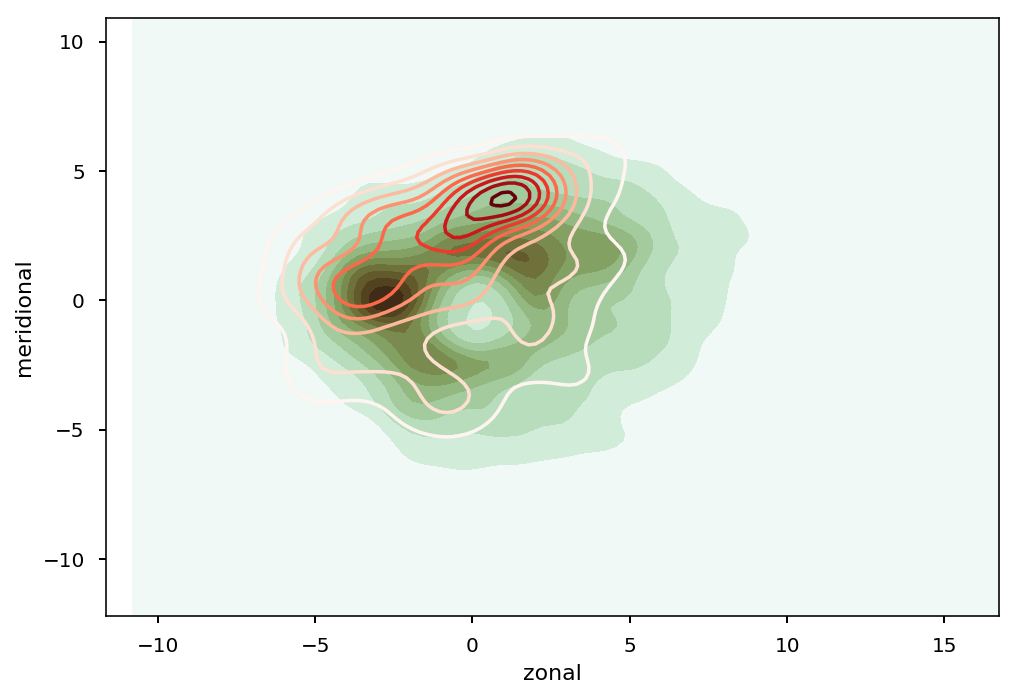

In [15]:
# Zonal x-coordinate
# meridional: y-coordinate
cmap = sns.cubehelix_palette(start=1, light=1, as_cmap=True)
ax=sns.kdeplot(data['zonal'], data['meridional'], cmap=cmap, shade=True, cut=5)
ax=sns.kdeplot(weather_forecast['zonal'], weather_forecast['meridional'], cmap='Reds', shade=False, cut=5,shade_lowest=False)



**Wind direction**

{'N': [348.75, 11.25], 'NNE': [11.25, 33.75], 'NE': [33.75, 56.25], 'ENE': [56.25, 78.75], 'E': [78.75, 101.25], 'ESE': [101.25, 123.75], 'SE': [123.75, 146.25], 'SSE': [146.25, 168.75], 'S': [168.75, 191.25], 'SSW': [191.25, 213.75], 'SW': [213.75, 236.25], 'WSW': [236.25, 258.75], 'W': [258.75, 281.25], 'WNW': [281.25, 303.75], 'NW': [303.75, 326.25], 'NNW': [326.25, 348.75]}


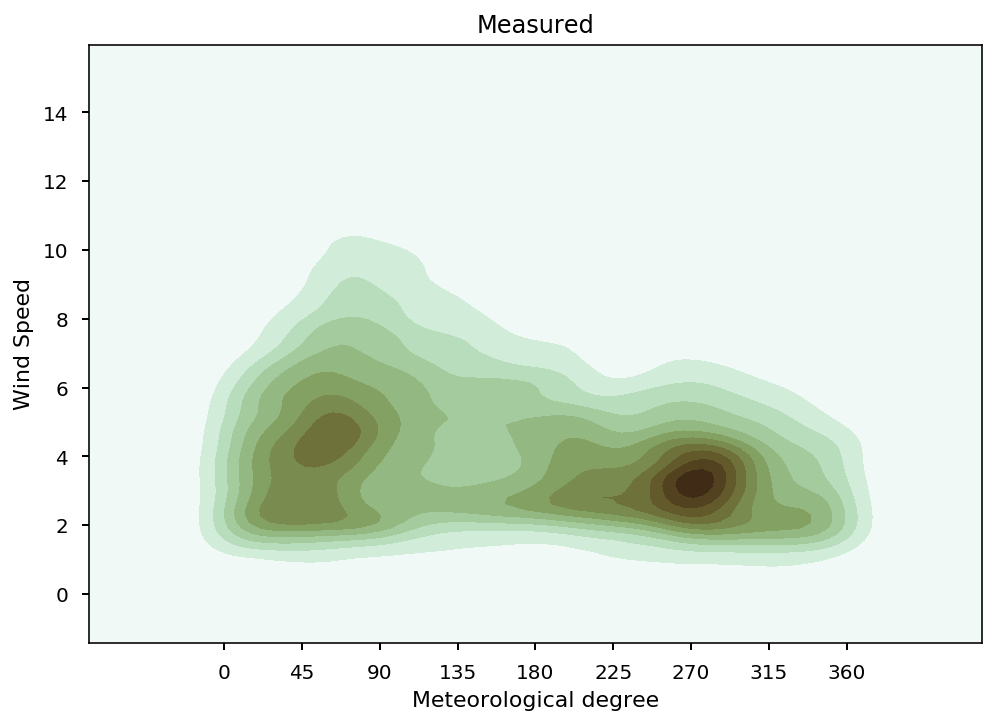

{'N': [348.75, 11.25], 'NNE': [11.25, 33.75], 'NE': [33.75, 56.25], 'ENE': [56.25, 78.75], 'E': [78.75, 101.25], 'ESE': [101.25, 123.75], 'SE': [123.75, 146.25], 'SSE': [146.25, 168.75], 'S': [168.75, 191.25], 'SSW': [191.25, 213.75], 'SW': [213.75, 236.25], 'WSW': [236.25, 258.75], 'W': [258.75, 281.25], 'WNW': [281.25, 303.75], 'NW': [303.75, 326.25], 'NNW': [326.25, 348.75]}


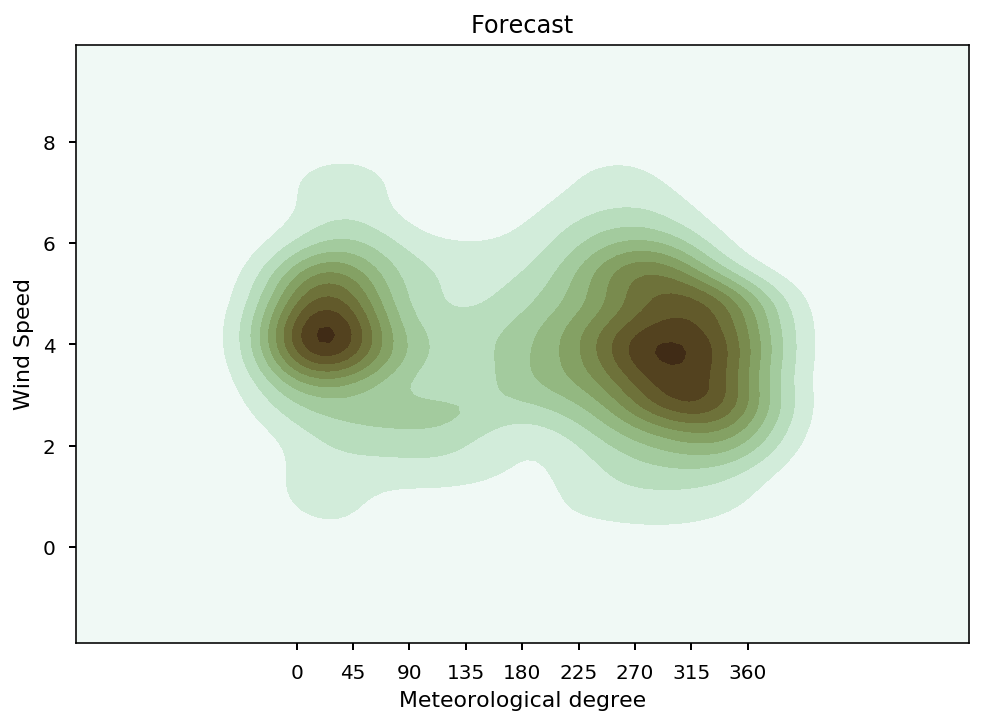

In [16]:


cardinal_degree = {
        'N'   : [348.75 ,  11.25],
        'NNE' : [11.25  ,  33.75],
        'NE'  : [33.75  ,  56.25],
        'ENE' : [56.25  ,  78.75],
        'E'   : [78.75  , 101.25],
        'ESE' : [101.25 , 123.75],
        'SE'  : [123.75 , 146.25],
        'SSE' : [146.25 , 168.75],
        'S'   : [168.75 , 191.25],
        'SSW' : [191.25 , 213.75],
        'SW'  : [213.75 , 236.25],
        'WSW' : [236.25 , 258.75],
        'W'   : [258.75 , 281.25],
        'WNW' : [281.25 , 303.75],
        'NW'  : [303.75 , 326.25],
        'NNW' : [326.25 , 348.75]
}

def wind_dir(data, title=None, plot=True):
    '''
    Dataset with zonal and meridional coordinates. Outputs the cardinal- and 
    the degree direction, respectively.
    '''
    car=[]
    deg=[]
    u,v = data['zonal'], data['meridional']
    wind_degree = 180/np.pi*np.arctan2(-u,-v)+180
    wind_dir = pd.DataFrame(columns=[['car_dir','deg_dir']],index=data.index)

    for ind, bear in enumerate(wind_degree):
        for direction, interval in cardinal_degree.items():
            low, high = interval    
            if bear >= low and bear < high:
                car.append(direction)
                deg.append(bear)
        if ind != len(car)-1:
            car.append('N')
            deg.append(bear)
            
    if plot:
      #pass
        plot_wind(u,v,deg,cardinal_degree,title)
    
    return car, deg

def plot_wind(u, v, degree, cardinal_degree, title, sel=-1):
    '''
    Plots wind speed against the meteorological degree.
    Cardinal directions with their respective degree range are also printed.
    '''
    cmap = sns.cubehelix_palette(start=1, light=1, as_cmap=True)
    sns.kdeplot(degree[:sel], np.sqrt(v[:sel]**2+u[:sel]**2), 
                cmap=cmap, shade=True, cut=5)
    plt.xlabel('Meteorological degree')
    plt.ylabel('Wind Speed')
    plt.xticks(np.arange(0,361,45))
    plt.title(title)
    print(cardinal_degree)#[i for i in cardinal_degree.keys()])
    plt.show()



data['car_dir'], data['deg_dir'] = wind_dir(data,'Measured')
weather_forecast['car_dir'], weather_forecast['deg_dir'] =\
                                        wind_dir(weather_forecast,'Forecast')


#print(pd.get_dummies(wind_dir))


In [17]:
# Interactive stuff
from ipywidgets import interact

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data.drop(columns=['car_dir']))
df_normalized = pd.DataFrame(np_scaled)
df_normalized.set_index(data.drop(columns=['car_dir']).index)
df_normalized.columns = data.drop(columns=['car_dir']).columns
df_normalized.drop(columns=['zonal','meridional'],inplace=True)
df_normalized.head()

# Hourly resolution
# One year: 8760
# One month: 720
# One day: 24
time = 24*7
@interact(all_columns=True, column_name=df_normalized.columns, t=(0,len(data),time))
def f(all_columns, column_name, t):
    if all_columns:
        df_normalized[t:time+t].plot(figsize=[20,5])
    else:
        df_normalized[column_name][t:time+t].plot(figsize=[20,5])
    plt.xlabel('Time')
    plt.ylabel('Normalised values')
    plt.title('Relationship')

A Jupyter Widget

## Building models

In [207]:

# Defining the regression models 

def linear_regression(X_train, y_train, X_test, y_test, plot=True):
    regr = LinearRegression()
    regr.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)

    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The Root mean squared error
    print("Root Mean squared error: %.4f"
          % np.sqrt(mean_squared_error(y_test, y_pred)))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(y_test, y_pred))
    
    if plot:
        # Plot outputs
        #plot_task1(X_test, y_test, y_pred, 'Linear Regression')
        plot_powergeneration(y_test, y_pred, 'Linear Regression')
    return y_pred
        

def k_nearest_neighbors(X_train, y_train, X_test, y_test, plot=True):
    neigh = KNeighborsRegressor(n_neighbors=800)
    neigh.fit(X_train_selected, y_train) 
    y_pred = neigh.predict(X_test)

    # The Root mean squared error
    print("Root Mean squared error: %.4f"
          % np.sqrt(mean_squared_error(y_test, y_pred)))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(y_test, y_pred))
    
    if plot:
        # Plot outputs
        #plot_task1(X_test, y_test, y_pred, 'KNN')
        plot_powergeneration(y_test, y_pred, 'KNN')


def support_vector_regression(X_train, y_train, X_test, y_test, plot=True):

    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
    y_pred = svr_rbf.fit(X_train_selected, y_train).predict(X_test_selected)


    # The Root mean squared error
    print("Root Mean squared error: %.4f"
          % np.sqrt(mean_squared_error(y_test, y_pred)))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(y_test, y_pred))
    
    if plot:
        #plot_task1(X_test, y_test, y_pred, 'SVR')
        plot_powergeneration(y_test, y_pred, 'SVR')
        
        

def ann_model(X_train, y_train, X_test, y_test, plot=True):
    '''
    Trains an artificial neural network. n-input channels and one 
    output(the predicted power).
    '''
    input_shape = X_train.shape[1]
    output_shape = 1
    model = Sequential()

    model.add(InputLayer(input_shape=(input_shape,)))
    #model.add(Dense(30, kernel_initializer='glorot_uniform',
                  #bias_initializer='ones', activation='relu'))
    #model.add(Dense(500,  kernel_initializer='glorot_uniform',
                  #bias_initializer='ones', activation='relu'))
    #model.add(Dense(250,  kernel_initializer='glorot_uniform',
                  #bias_initializer='ones', activation='relu'))
    #model.add(Dense(55,   kernel_initializer='glorot_uniform',
                  #bias_initializer='ones', activation='relu'))
    model.add(Dense(6, kernel_initializer='lecun_normal',
                    bias_initializer='ones',activation='selu'))
    model.add(Dropout(0.3))
    model.add(Dense(8, kernel_initializer='lecun_normal',
                    bias_initializer='ones',activation='softmax'))
    model.add(Dense(output_shape))

    model.compile(optimizer='rmsprop',
                loss='mean_squared_error')  #batch_size=2000, epochs=100,

    model.fit(X_train, y_train,epochs=10,  verbose=1)

    y_pred = model.predict(X_test)

    # The Root mean squared error
    print("Root Mean squared error: %.4f"
        % np.sqrt(mean_squared_error(y_test, y_pred)))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(y_test, y_pred))

    if plot:
        plot_powergeneration(y_test, y_pred, model='ANN')
 


# Store predictions to file function        
def store_predictions_to_file(y_pred, model=None, task=1 , 
                              template='ForecastTemplate.csv'):
    pred = pd.read_csv(template)
    pred['FORECAST'] = y_pred[:len(pred)]
    pred.to_csv('ForecastTemplate{1}-{0}.csv'.format(model,task), index=False)
        
        
        
# Plotting function

def plot_powergeneration(y_test, y_pred, model=None):
    
    plt.figure(figsize=(15,5))
   
    plt.plot(y_test.values, color='darkorange', label='Real')
    
    plt.plot(y_pred, color='navy', label='Predicted')
    
    plt.xlabel('Time')
    plt.ylabel('Wind Power')
    plt.title(model)
    plt.legend()
    #plt.ylim(-0.1,y_test.max().all()+0.1)
    plt.show()
    

def plot_task1(X_test, y_test, y_pred, model=None):
    plt.scatter(X_test, y_test, color='darkorange', 
            marker='.', label='Real', linewidth=0.1)
    
    plt.scatter(X_test, y_pred, color='navy', 
                marker='.', label='Predicted', linewidth=0.1)
    
    plt.xlabel('Wind speed')
    plt.ylabel('Wind Power')
    plt.title(model)
    plt.legend()
    plt.ylim(-0.1,y_test.max().all()+0.1)
    plt.show()

    

# Task 1

**Selecting training dataset**

In [19]:

train = data.drop('POWER', 1)
train_y = data['POWER']#.reshape(-1,1)

#X_train, X_test, y_train, y_test =\
#        train_test_split(train,train_y,test_size=0.3,random_state=1)
sel=-1               
X_train = train[:sel]
y_train = train_y[:sel]

X_test = weather_forecast
y_test = solution
            
X_train_selected = X_train['windspeed'].values.reshape(-1 ,1)
X_test_selected = X_test['windspeed'].values.reshape(-1 ,1)
            
print(X_train_selected.shape,X_test_selected.shape, y_train.shape, y_test.shape)

(16079, 1) (720, 1) (16079,) (720, 1)


**Training and predicting**

Coefficients: 
 [ 0.12259219]
Root Mean squared error: 0.2164
Variance score: 0.45


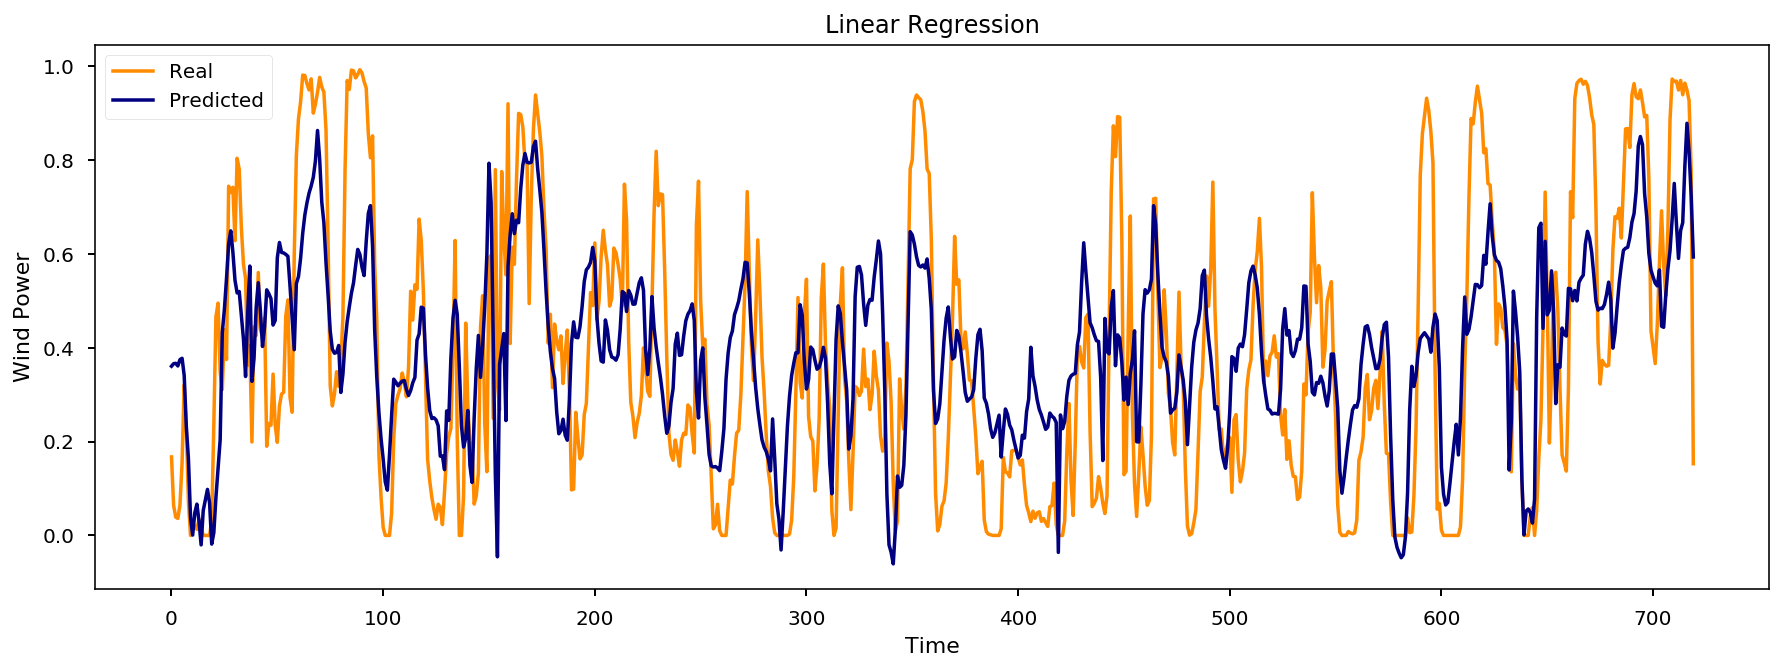

Root Mean squared error: 0.2167
Variance score: 0.45


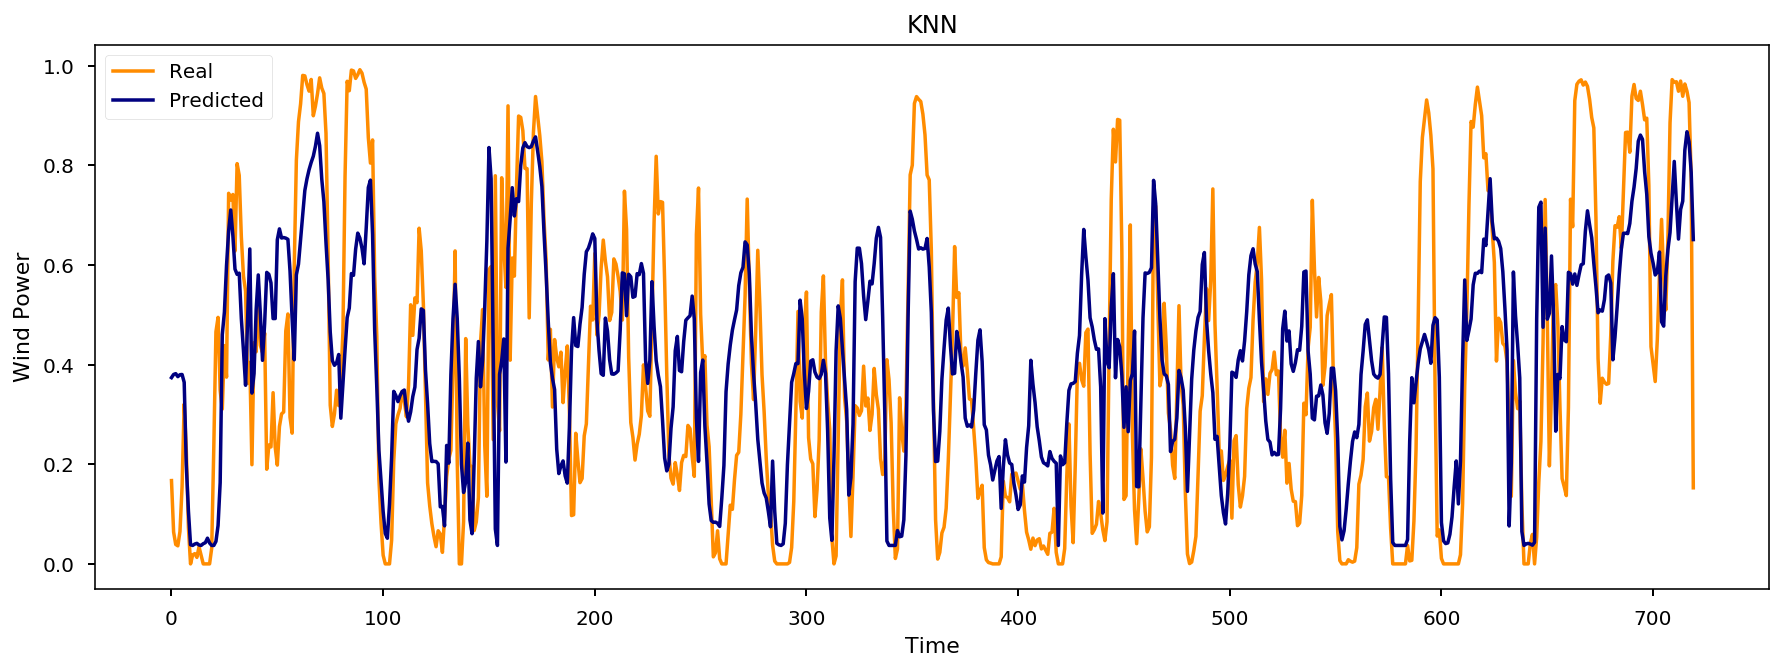

Root Mean squared error: 0.2138
Variance score: 0.47


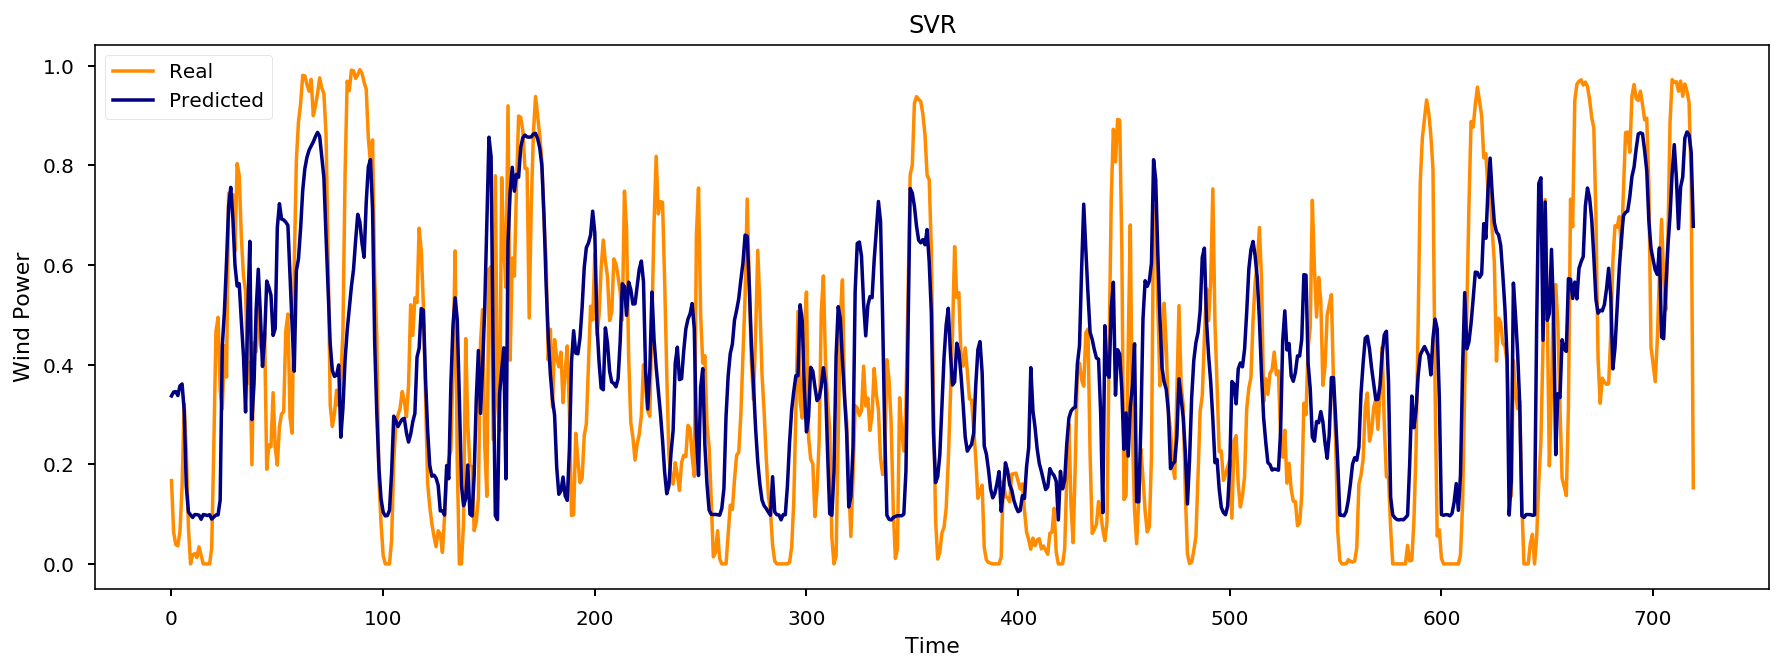

Epoch 1/10
16079/16079 [==============================] - 3s 216us/step - loss: 0.0713
Epoch 2/10
16079/16079 [==============================] - 1s 58us/step - loss: 0.0551
Epoch 3/10
16079/16079 [==============================] - 1s 57us/step - loss: 0.0540
Epoch 4/10
16079/16079 [==============================] - 1s 59us/step - loss: 0.0538
Epoch 5/10
16079/16079 [==============================] - 1s 59us/step - loss: 0.0534
Epoch 6/10
16079/16079 [==============================] - 1s 58us/step - loss: 0.0533
Epoch 7/10
16079/16079 [==============================] - 1s 66us/step - loss: 0.0530
Epoch 8/10
16079/16079 [==============================] - 1s 62us/step - loss: 0.0527
Epoch 9/10
16079/16079 [==============================] - 1s 60us/step - loss: 0.0528
Epoch 10/10
16079/16079 [==============================] - 1s 61us/step - loss: 0.0529
Root Mean squared error: 0.2137
Variance score: 0.47


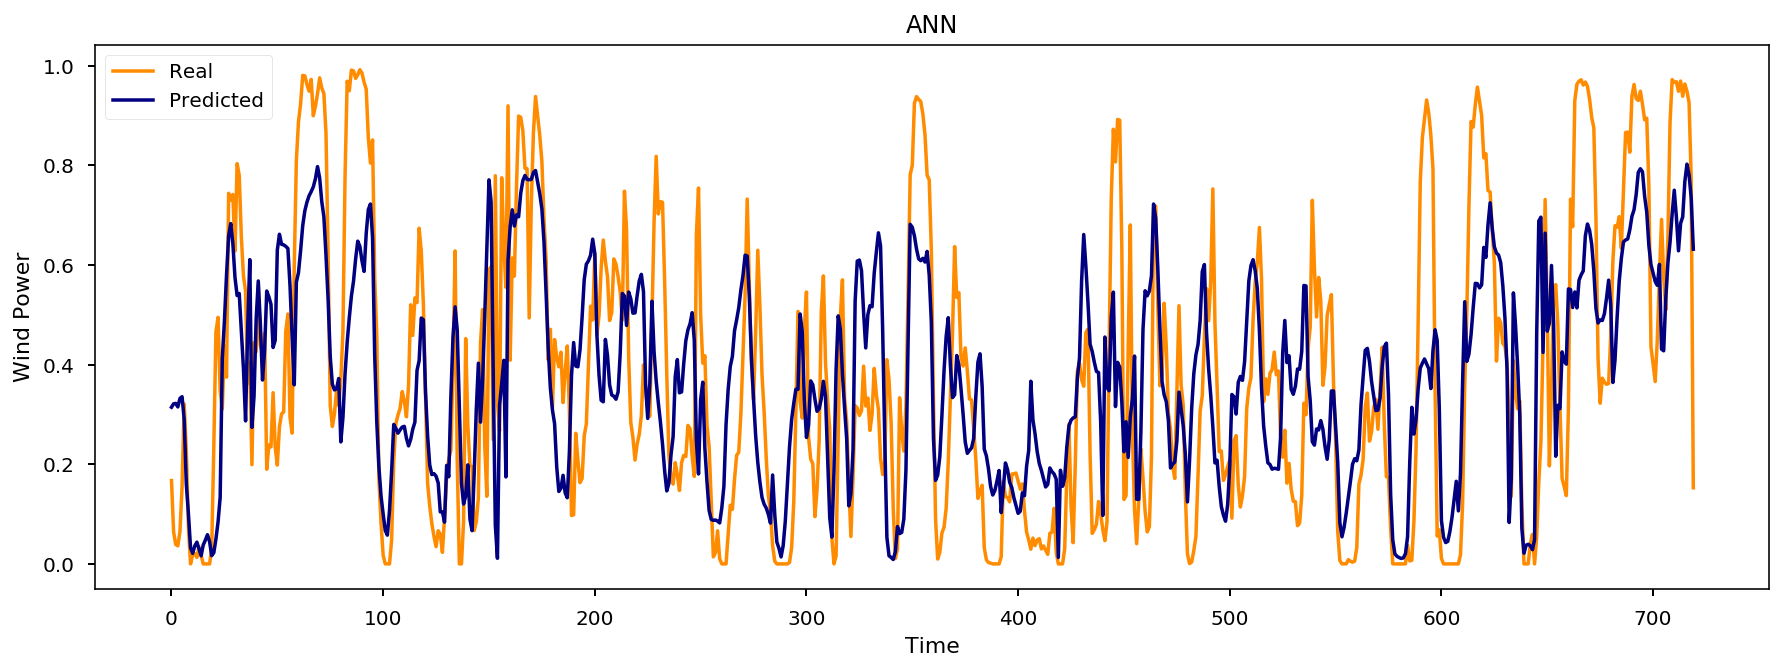

In [209]:
np.random.seed(1)
train_test = X_train_selected, y_train, X_test_selected, y_test

linear_regression(*train_test)
k_nearest_neighbors(*train_test)
support_vector_regression(*train_test)
ann_model(*train_test)

In [97]:
store_predictions_to_file(y_pred, 'KNN', task=2)  

NameError: name 'y_pred' is not defined

# Task 2

In [ ]:
# Define dataset
train = data.drop('POWER', 1)
train_y = data['POWER']#.reshape(-1,1)

#X_train, X_test, y_train, y_test =\
#        train_test_split(train,train_y,test_size=0.3,random_state=1)
                        
X_train = train
y_train = train_y

X_test = weather_forecast
y_test = solution

X_train_one = X_train['windspeed'].values.reshape(-1 ,1)
X_test_one = X_test['windspeed'].values.reshape(-1 ,1)

X_train_two = X_train[['windspeed','deg_dir']]
X_test_two = X_test[['windspeed','deg_dir']]

**Training and prediction**

In [ ]:
train_test_two = X_train_two, y_train, X_test_two, y_test
train_test_one = X_train_one, y_train, X_test_one, y_test

lr_pred=linear_regression(*train_test_one,plot=False)
mlr_pred=linear_regression(*train_test_two,plot=False)


# Plotting MLR, LR and real values
plt.figure(figsize=(15,5))

plt.plot(y_test.values, color='darkorange', label='Real')

plt.plot(mlr_pred, color='navy', label='MLR_Predicted')
plt.plot(lr_pred, color='darkgreen', label='LR_Predicted')

plt.xlabel('Time')
plt.ylabel('Wind Power')
plt.title('MLR and LR')
plt.legend()
#plt.ylim(-0.1,y_test.max().all()+0.1)
plt.show()

# Task 3 

In [ ]:
weather_forecast.head()